In [22]:
import sys
sys.path.append("..")

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils
importlib.reload(utils);
from utils import *
from termcolor import colored
from tensorflow.keras import layers, Model, Input #type: ignore


### Wczytywanie danych


In [32]:
csv_path  = '../data/list_eval_partition.csv'
bbox_path = '../data/bbox_celeba.csv'
image_dir = '../data/img_align_celeba/img_align_celeba/'
BATCH_SIZE = 64

df_partition = pd.read_csv(csv_path)
df_data = pd.read_csv(bbox_path)
df = pd.merge(df_data, df_partition, on='image_id')
face_filter = df["face_detected"] == 1
df = df[face_filter].drop(columns=["face_detected"])

df_train = df[df["partition"] == 0].drop(columns=["partition"])
df_val = df[df["partition"] == 1].drop(columns=["partition"])
df_test = df[df["partition"] == 2].drop(columns=["partition"])

train_ds = make_image_dataset(df_train,image_dir,img_size=(64,64),batch_size=BATCH_SIZE,shuffle=True)
val_ds = make_image_dataset(df_val,image_dir,img_size=(64,64),batch_size=BATCH_SIZE)
test_ds = make_image_dataset(df_test,image_dir,img_size=(64,64),batch_size=BATCH_SIZE)


### Wczytywanie modelu


In [3]:
BATCH_SIZE = 64
latent_dim = 256
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #batch = tf.shape(z_mean)[0]
        #dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(BATCH_SIZE, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder,beta=0.1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return z_mean,z_log_var,reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstructed = self(data)

            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            reconstruction_loss = tf.reduce_mean(
                    #tf.keras.losses.binary_crossentropy(data, reconstructed)
                    tf.keras.losses.MeanSquaredError()(data,reconstructed)
                    
            )
            total_loss = self.beta * kl_loss + reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}
    def test_step(self,data):
        z_mean, z_log_var, reconstructed = self(data)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        reconstruction_loss = tf.reduce_mean(
            #tf.keras.losses.binary_crossentropy(data, reconstructed)
            tf.keras.losses.MeanSquaredError()(data,reconstructed)
        )
        total_loss = self.beta * kl_loss + reconstruction_loss
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}

In [21]:
print(colored("Encoder:","red"))
encoder_inputs = Input(shape=(64, 64, 3), name="encoder_input")  
x = layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation="relu")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean    = layers.Dense(latent_dim, name="z_mean")(x)      
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean,z_log_var,z], name="encoder")
z_predict = encoder.predict(train_ds.take(1))
print(colored("Test prediction shape of 1 batch:","blue"),z_predict[0].shape)

print(colored("Decoder:","red"))
decoder_input = Input(shape=(latent_dim,), name="z_input")
x = layers.Dense(8 * 8 * latent_dim, activation="relu")(decoder_input)
x = layers.Reshape((8, 8, latent_dim))(x)
x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32,  kernel_size=5, strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2DTranspose(
        3, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(decoder_input, decoder_output, name="conv_decoder")
predict = decoder.predict(z_predict[2])
print(colored("Test prediction shape of 1 batch:","blue"),predict.shape)

Encoder:
1/1 [==============================] - 1s 518ms/step
Test prediction shape of 1 batch: (64, 256)
Decoder:
2/2 [==============================] - 0s 65ms/step
Test prediction shape of 1 batch: (64, 64, 64, 3)


In [13]:
vae = VAE(encoder, decoder,beta=0.01)
vae.build((None, 64, 64, 3))
vae.load_weights('vae_weights2.h5')
# Model must be compiled to use model.evaluate()
vae.compile(optimizer=tf.keras.optimizers.Adam())


### Ewaluacja modelu na zbiorze testowym


In [14]:
result = vae.evaluate(test_ds)
print(colored("Test total loss:","blue"),result[1])
print(colored("Test (unscaled) KL loss:","blue"),result[0])
print(colored("Test reconstruction loss:","blue"),result[2])

298/298 [==============================] - 27s 88ms/step - loss: 0.0088 - kl_loss: 0.3146 - reconstruction_loss: 0.0056
Test total loss: 0.008656731806695461
Test (unscaled) KL loss: 0.3078894019126892
Test reconstruction loss: 0.00557783804833889


Wartość funkcji straty na zbiorze testowym jest bardzo zbliżona do wartości na zbiorze treningowym i walidacyjnym, co sugeruje że model dobrze sie generalizuje.

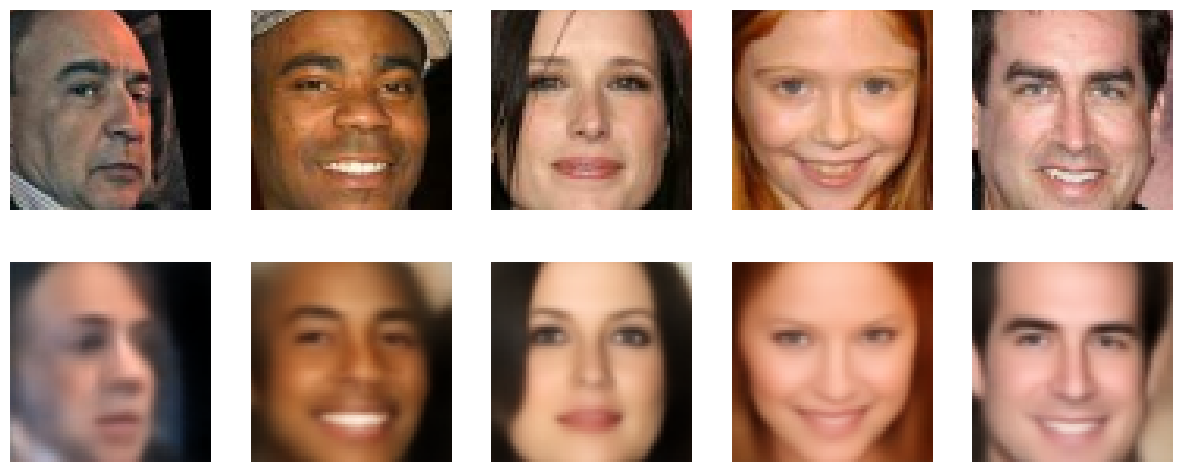

In [ ]:
example = next(iter(test_ds))

index = np.random.randint(0, BATCH_SIZE,5)
fig,axes = plt.subplots(2,5,figsize=(15, 6))

for i,idx in enumerate(index):
    output = vae(example)[2][idx]
    pil_img = tf.keras.preprocessing.image.array_to_img(example[idx].numpy())
    axes[0,i].imshow(pil_img)
    pil_img = tf.keras.preprocessing.image.array_to_img(output.numpy())
    axes[1,i].imshow(pil_img)
    axes[0,i].axis('off')
    axes[1,i].axis('off')
plt.show()


### Tworzenie nowych obrazów


Generated images from random points in latent space:


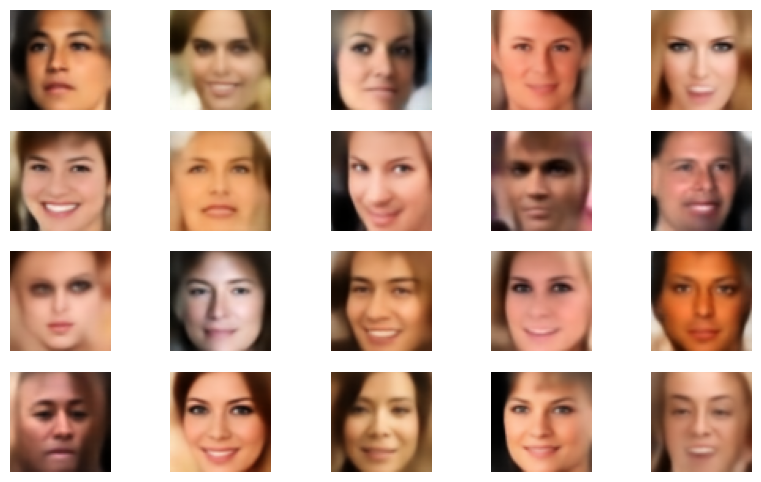

In [115]:
num_photos = 5*4
z = tf.random.normal(shape=(num_photos, latent_dim))
output = vae.decoder(z)
fig,axes = plt.subplots(num_photos//5,5,figsize=(10, 6))
for i,ax in zip(np.arange(num_photos),axes.flatten()):
    pil_img = tf.keras.preprocessing.image.array_to_img(output[i].numpy())
    ax.imshow(pil_img)
    ax.axis('off')
print(colored("Generated images from random points in latent space:","blue"))
plt.show()


### Manipulacja atrybutami


Smiling images


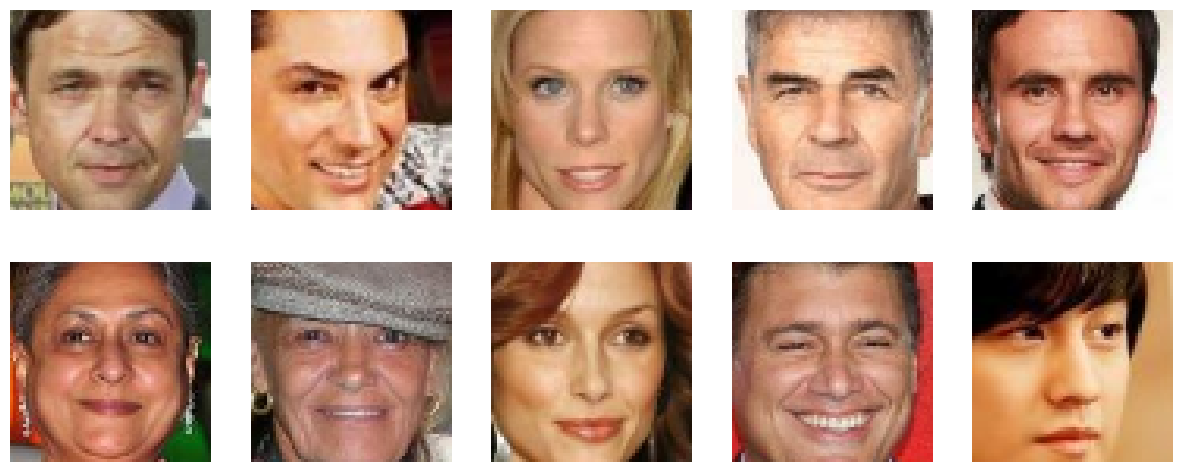

Non-smiling images


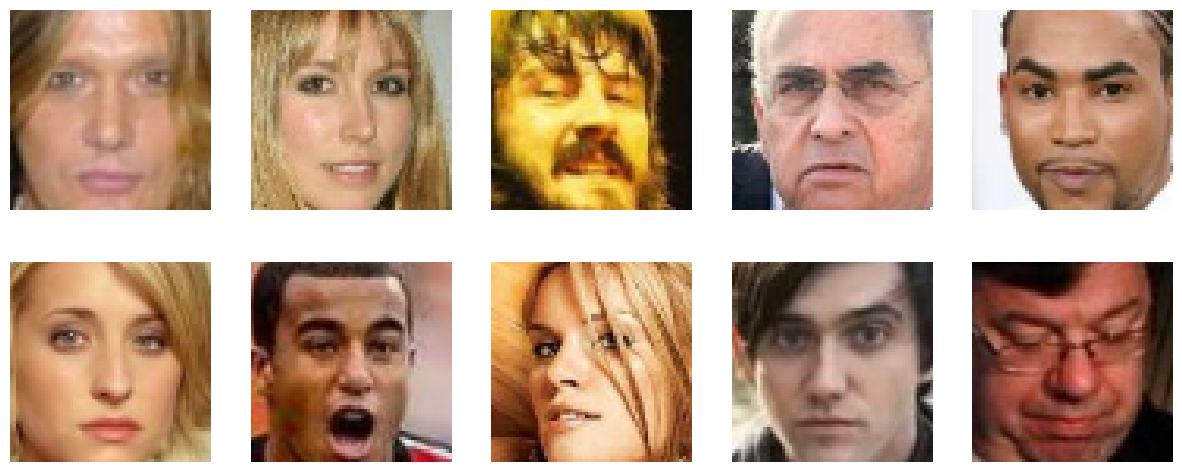

In [111]:
FEATURE = 'Smiling'

df_features = pd.read_csv("../data/list_attr_celeba.csv")
df_features = df_features[face_filter]

smile_filter = df_features[FEATURE]==1
df_smile = df[smile_filter]
non_smile_filter = df_features[FEATURE] == -1
df_non_smile = df[non_smile_filter]

non_smile_ds = make_image_dataset(df_non_smile, image_dir, img_size=(64,64), batch_size=BATCH_SIZE, shuffle=True)
smile_ds = make_image_dataset(df_smile,image_dir,img_size=(64,64),batch_size=BATCH_SIZE,shuffle=True)

for batch in smile_ds.take(1):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    idx = np.random.choice(np.arange(0, 64), size=10, replace=False)
    for i, ax in zip(idx, axes):
        img = tf.keras.utils.array_to_img(batch[i],data_format="channels_last",scale=True)
        ax.imshow(img)
        ax.axis('off')
print(colored("Smiling images","green"))
plt.show()

for batch in non_smile_ds.take(1):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    idx = np.random.choice(np.arange(0, 64), size=10, replace=False)
    for i, ax in zip(idx, axes):
        img = tf.keras.utils.array_to_img(batch[i],data_format="channels_last",scale=True)
        ax.imshow(img)
        ax.axis('off')
print(colored("Non-smiling images","green"))
plt.show()

Tworzenie wektora odpowiedzialnego za uśmiechanie

In [46]:
z_smile = vae.encoder.predict(smile_ds)[0].mean(axis=0)
z_non_smile = vae.encoder.predict(non_smile_ds)[0].mean(axis=0)
z_smile_direction = z_smile - z_non_smile

1524/1524 [==============================] - 140s 92ms/step


2/2 [==============================] - 0s 32ms/step


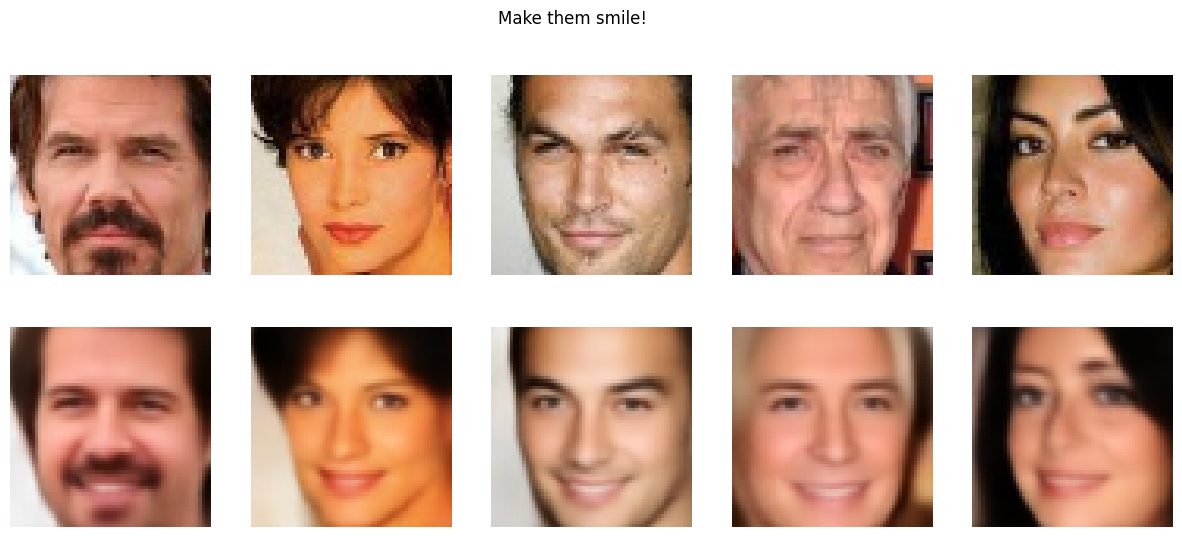

In [110]:
example = next(iter(ds))
z_make_smile = vae.encoder(example)[2] + z_smile_direction
make_smile = vae.decoder.predict(z_make_smile)

index = np.random.randint(0, BATCH_SIZE,5)
fig,axes = plt.subplots(2,5,figsize=(15, 6))

for i,idx in enumerate(index):
    output = make_smile[idx]
    pil_img = tf.keras.preprocessing.image.array_to_img(example[idx].numpy())
    axes[0,i].imshow(pil_img)
    pil_img = tf.keras.preprocessing.image.array_to_img(output)
    axes[1,i].imshow(pil_img)
    axes[0,i].axis('off')
    axes[1,i].axis('off')
plt.suptitle("Make them smile!")
plt.show()


### Interpolacja pomiędzy dwoma twarzami


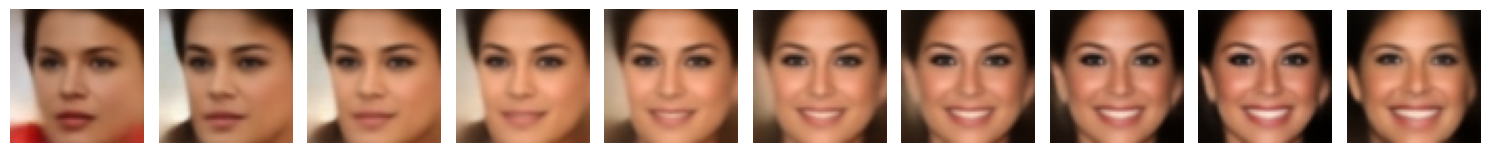

In [106]:
example = next(iter(val_ds))
# choose two photos
photo_1,photo_2 = vae(example)[2][34:35].numpy(),vae(example)[2][47:48].numpy() 
z = vae.encoder(example)[2]
z_1,z_2 = z[34:35],z[47:48]

# number of interpolation steps
n = 8 
alphas = tf.reshape(tf.linspace(0.0, 1.0, n), (-1, 1))  # shape (n, 1)

# Interpolate and concatenate
interpolated = (1 - alphas) * z_1 + alphas * z_2
output = vae.decoder(interpolated).numpy()
photos = np.concatenate([photo_1,output,photo_2],axis=0)

fig,axes = plt.subplots(1,n+2,figsize=(15, 6))
for i in range(n+2):
    pil_img = tf.keras.preprocessing.image.array_to_img(photos[i])
    axes[i].imshow(pil_img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()